<a href="https://colab.research.google.com/github/ce3tnia/DeepLearning/blob/master/TransferLearning_ResNeXt101_CocoaBeans_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import numpy as np
import pickle
import cv2
import keras

from keras_applications.resnext import ResNeXt101
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.layers import BatchNormalization

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt 

from os import listdir
from keras import backend as K
from keras.layers import Input
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [ ]:
epochs = 50
init_lr = 1e-3
batch_sizes = 32
default_image_size = tuple((64, 64))
image_size = 0
directory_root = "/content/drive/MyDrive/dataset/cocoa beans"
size = 64
n_ch = 3
input_sizes = (size,size,n_ch)

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir) 
        if image is not None :
            image = cv2.resize(image, default_image_size)  
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:105]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    %time print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Image loading completed
CPU times: user 137 µs, sys: 0 ns, total: 137 µs
Wall time: 114 µs


In [ ]:
image_size = len(image_list)
print(image_size)

614


In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [ ]:
print(n_classes)

6


In [ ]:
#rescale
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.3, random_state = 42)

In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    vertical_flip=True,
    horizontal_flip=True, 
    fill_mode="nearest")

# **Arsitektur ResNeXt101**

In [ ]:
def define_model_resnext101():
  base_model = ResNeXt101(input_tensor=Input(shape = (size, size, n_ch)), include_top = False, weights = 'imagenet', 
        backend = keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)
    
  base_model.trainable = False  

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(n_classes, activation= 'softmax', name='root')(x)

  model = Model(inputs=base_model.input,outputs=output)

  model.compile(optimizer=Adam(lr=init_lr, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),loss="binary_crossentropy",metrics=["accuracy"])
  model.summary()
  return model

In [ ]:
class Callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.94 and logs.get('val_accuracy') >= 0.94):
      print("\n\akurasi telah mencapai lebih dari 94% dan akurasi validasi telah mencapai 0.94")
      self.model.stop_training = True

stopProcess = Callback()

In [ ]:
model = define_model_resnext101()

aug.fit(x_train)

history = model.fit_generator(aug.flow(x_train, y_train, batch_size=batch_sizes),
               steps_per_epoch=x_train.shape[0] // batch_sizes,
               epochs=epochs,
               verbose=1,callbacks=[stopProcess],
               validation_data=(x_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

169975808/169972280 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32,

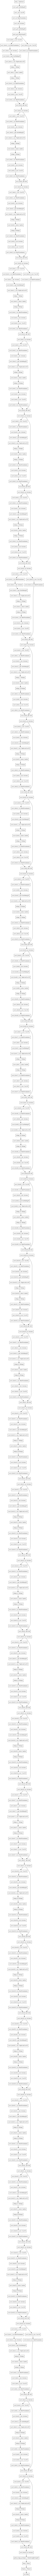

In [ ]:
keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

185/185 [==============================] - 0s 3ms/step
Test Accuracy: 93.69369745254517


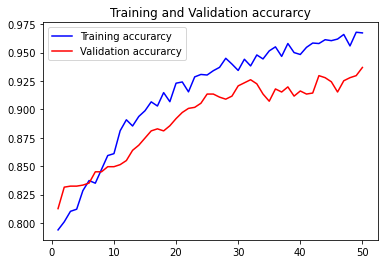

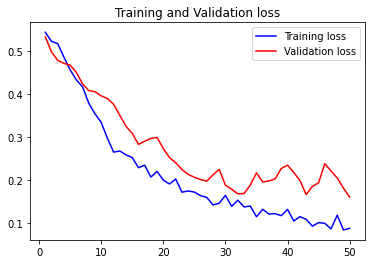

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [ ]:
model_pred = model.predict(x_test, batch_sizes, verbose=2)
model_predicted = np.argmax(model_pred, axis=1)

[[28  2  0  0  0  0]
 [ 0 25  1  5  0  0]
 [ 0  4 14  3  4  0]
 [ 0  6  0 33  1  0]
 [ 0  0  7  2 20  0]
 [ 0  0  1  0  0 29]]


<Figure size 432x288 with 0 Axes>

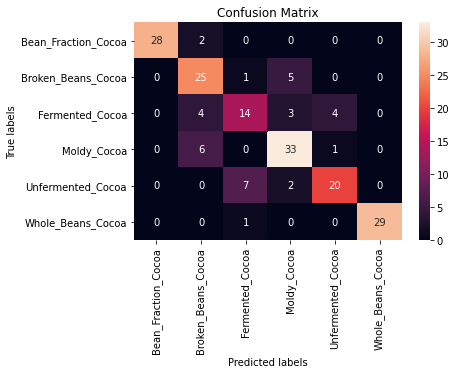

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test2 = np.argmax(y_test,axis=1)

cm = confusion_matrix(y_test2,pred)
np.set_printoptions(precision=2)
print(cm)
plt.figure()

plt.figure()
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(label_binarizer.classes_,rotation=90) 
ax.yaxis.set_ticklabels(label_binarizer.classes_,rotation=0);

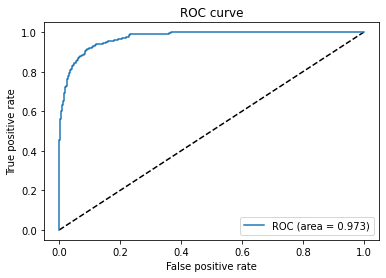

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test.ravel(), model_pred.ravel())
auc_ = auc(fpr, tpr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='ROC (area = {:.3f})'.format(auc_))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
print(len(x_test))

185


In [ ]:
print(label_binarizer.classes_)

['Bean_Fraction_Cocoa' 'Broken_Beans_Cocoa' 'Fermented_Cocoa'
 'Moldy_Cocoa' 'Unfermented_Cocoa' 'Whole_Beans_Cocoa']


In [ ]:
class_to_label_map={ 0:'Bean_Fraction_Cocoa', 1:'Broken_Beans_Cocoa', 2:'Fermented_Cocoa', 3:'Moldy_Cocoa', 4:'Unfermented_Cocoa', 5:'Whole_Beans_Cocoa'}

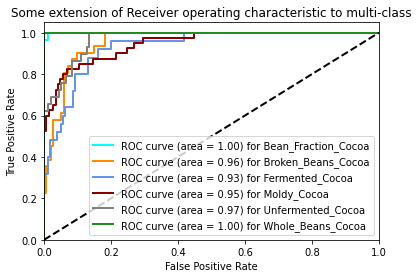

In [ ]:
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'grey', 'forestgreen'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))
    i=i+1
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()